In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Load and preprocess MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader = DataLoader(train_dataset + test_dataset, batch_size=256, shuffle=False)

all_imgs = []
all_labels = []
for imgs, labels in data_loader:
    all_imgs.append(imgs)
    all_labels.append(labels)
x = torch.cat(all_imgs).to(device)
y = torch.cat(all_labels).cpu().numpy()

In [17]:
# Define Convolutional Autoencoder

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()  # if input is normalized [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


model = ConvAutoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [18]:
# Train the model
for epoch in range(50):
    total_loss = 0
    for imgs, _ in DataLoader(train_dataset + test_dataset, batch_size=256, shuffle=True):
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 22.0109
Epoch 2, Loss: 18.1587
Epoch 3, Loss: 17.7208
Epoch 4, Loss: 17.5075
Epoch 5, Loss: 17.3692
Epoch 6, Loss: 17.2435
Epoch 7, Loss: 17.1065
Epoch 8, Loss: 17.0247
Epoch 9, Loss: 16.9456
Epoch 10, Loss: 16.9116
Epoch 11, Loss: 16.8374
Epoch 12, Loss: 16.8067
Epoch 13, Loss: 16.7682
Epoch 14, Loss: 16.7359
Epoch 15, Loss: 16.7086
Epoch 16, Loss: 16.6763
Epoch 17, Loss: 16.6581
Epoch 18, Loss: 16.6469
Epoch 19, Loss: 16.6218
Epoch 20, Loss: 16.6090
Epoch 21, Loss: 16.5937
Epoch 22, Loss: 16.5720
Epoch 23, Loss: 16.5685
Epoch 24, Loss: 16.5538
Epoch 25, Loss: 16.5510
Epoch 26, Loss: 16.5330
Epoch 27, Loss: 16.5356
Epoch 28, Loss: 16.5253
Epoch 29, Loss: 16.5086
Epoch 30, Loss: 16.5116
Epoch 31, Loss: 16.4861
Epoch 32, Loss: 16.4804
Epoch 33, Loss: 16.4736
Epoch 34, Loss: 16.4694
Epoch 35, Loss: 16.4715
Epoch 36, Loss: 16.4464
Epoch 37, Loss: 16.4533
Epoch 38, Loss: 16.4453
Epoch 39, Loss: 16.4479
Epoch 40, Loss: 16.4314
Epoch 41, Loss: 16.4318
Epoch 42, Loss: 16.4274
E

In [19]:
# Extract encoded features
model.eval()
with torch.no_grad():
    encoded_imgs = model.encoder(x).cpu().numpy()

encoded_imgs_flat = encoded_imgs.reshape(encoded_imgs.shape[0], -1)

In [20]:
# PCA to reduce dimensionality
pca = PCA(n_components=50)
x_pca = pca.fit_transform(encoded_imgs_flat)


In [22]:
# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_preds = kmeans.fit_predict(x_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
# Evaluation
ari = adjusted_rand_score(y, cluster_preds)
nmi = normalized_mutual_info_score(y, cluster_preds)
silhouette = silhouette_score(x_pca, cluster_preds)

print("\nClustering Results (KMeans on PCA of CAE features):")
print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}, Silhouette Score: {silhouette:.4f}")


Clustering Results (KMeans on PCA of CAE features):
ARI: 0.3964, NMI: 0.5226, Silhouette Score: 0.1030


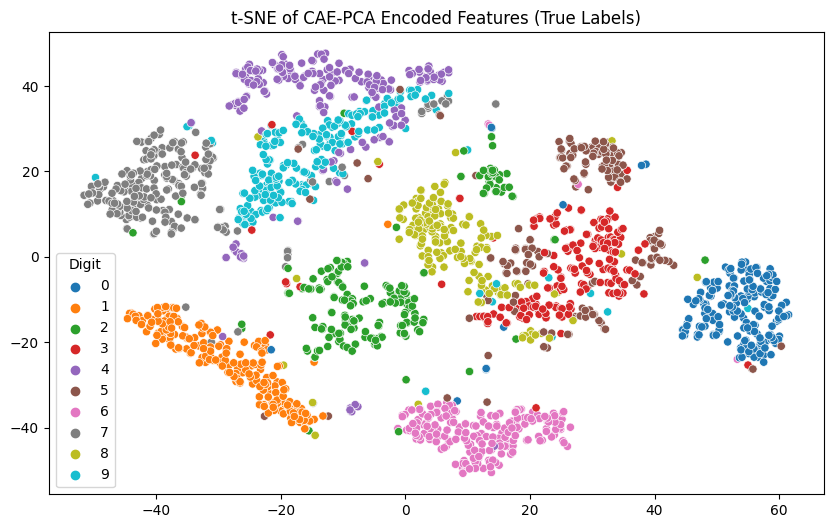

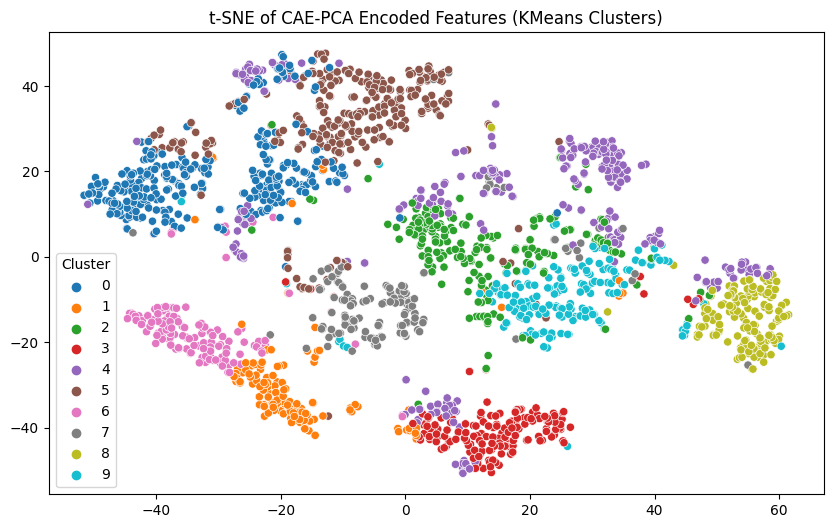

In [24]:
# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(x_pca[:2000])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=y[:2000], palette='tab10', legend='full')
plt.title("t-SNE of CAE-PCA Encoded Features (True Labels)")
plt.legend(title='Digit')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=cluster_preds[:2000], palette='tab10', legend='full')
plt.title("t-SNE of CAE-PCA Encoded Features (KMeans Clusters)")
plt.legend(title='Cluster')
plt.show()


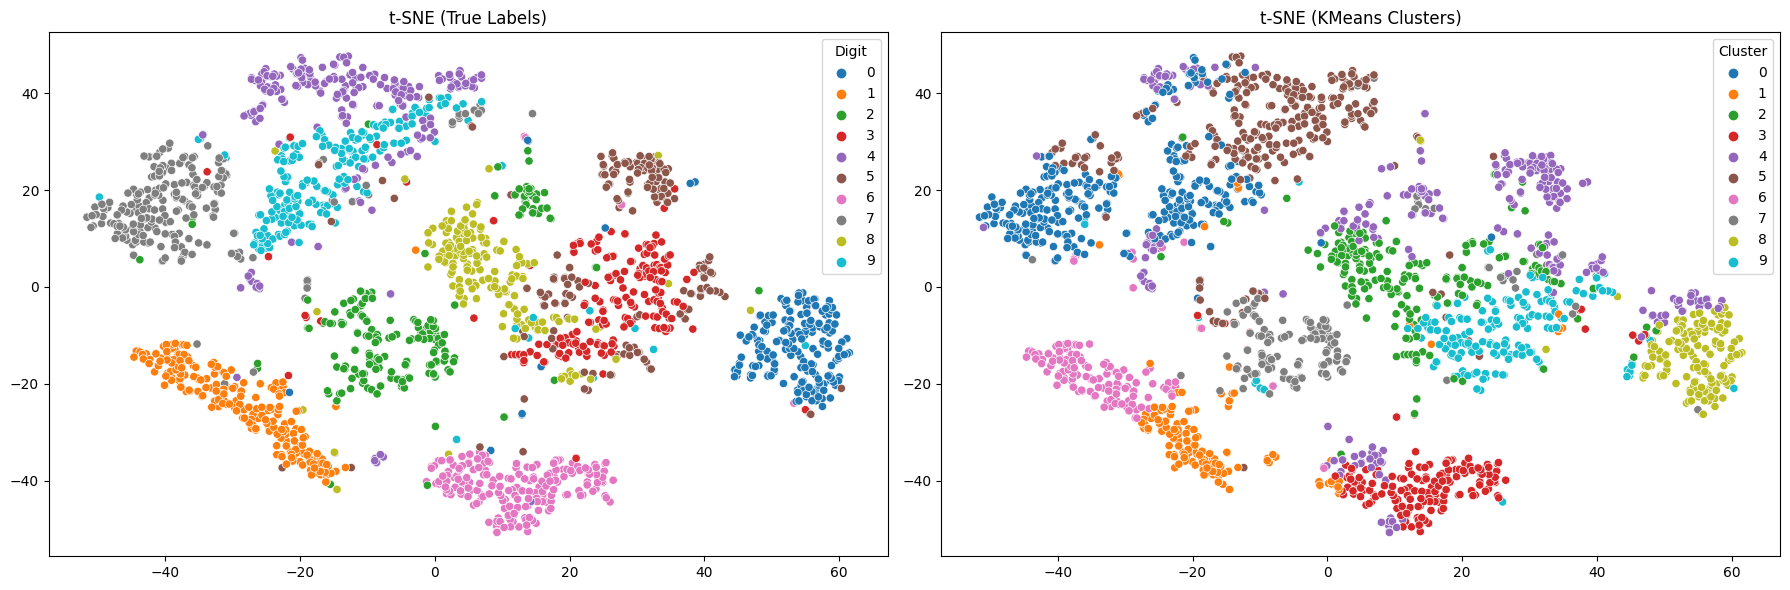

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot(ax=axes[0], x=x_tsne[:, 0], y=x_tsne[:, 1], hue=y[:2000], palette='tab10', legend='full')
axes[0].set_title("t-SNE (True Labels)")
axes[0].legend(title='Digit')

sns.scatterplot(ax=axes[1], x=x_tsne[:, 0], y=x_tsne[:, 1], hue=cluster_preds[:2000], palette='tab10', legend='full')
axes[1].set_title("t-SNE (KMeans Clusters)")
axes[1].legend(title='Cluster')

plt.tight_layout()
plt.show()


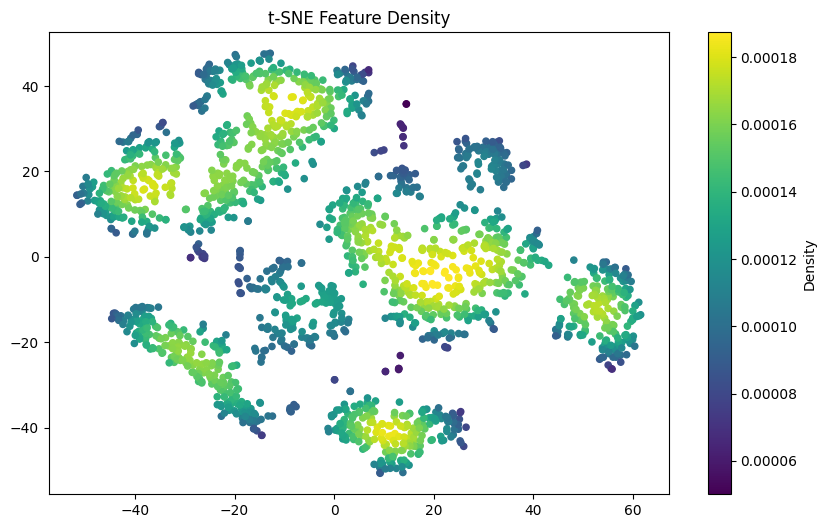

In [27]:
import seaborn as sns
from scipy.stats import gaussian_kde

# Density heatmap
xy = x_tsne.T
z = gaussian_kde(xy)(xy)

plt.figure(figsize=(10, 6))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=z, s=20, cmap='viridis')
plt.title("t-SNE Feature Density")
plt.colorbar(label='Density')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


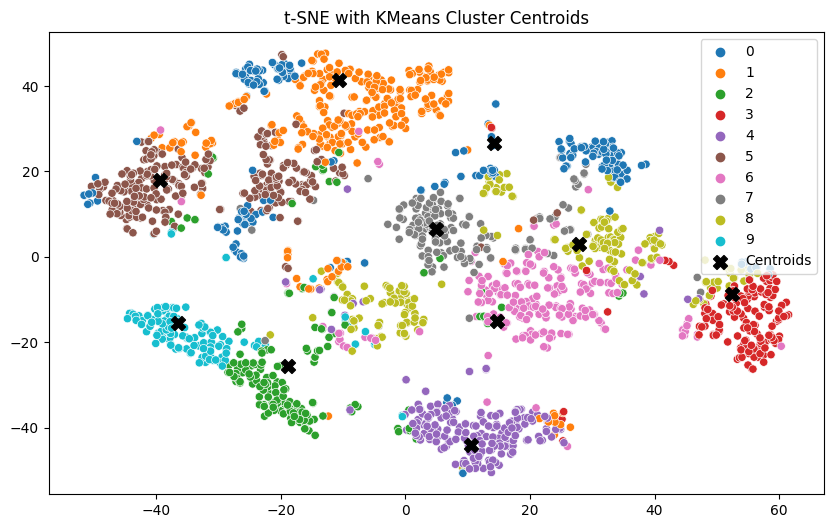

In [28]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming you have already applied PCA and KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_preds = kmeans.fit_predict(x_pca[:2000])
centroids_pca = kmeans.cluster_centers_

# Project centroids with same t-SNE transform
centroids_tsne = tsne.fit_transform(np.vstack([x_pca[:2000], centroids_pca]))[-10:]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=cluster_preds, palette='tab10', legend='full')
plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], color='black', s=100, marker='X', label='Centroids')
plt.title("t-SNE with KMeans Cluster Centroids")
plt.legend()
plt.show()


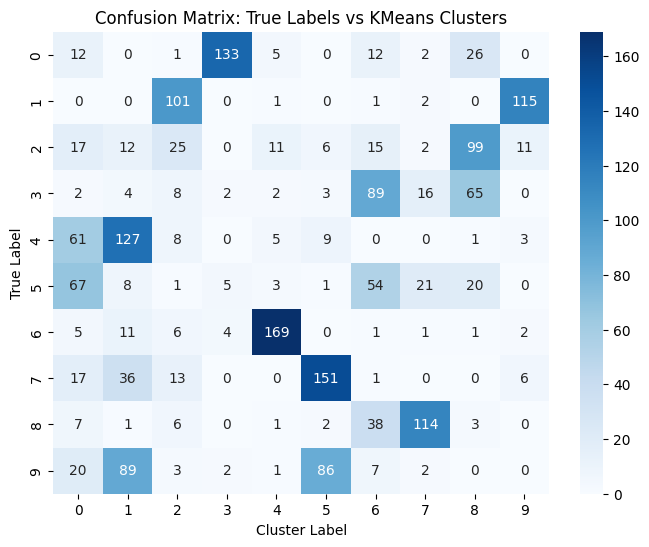

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y[:2000], cluster_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: True Labels vs KMeans Clusters")
plt.xlabel("Cluster Label")
plt.ylabel("True Label")
plt.show()


In [32]:
import plotly.express as px
import pandas as pd

df_tsne = pd.DataFrame(x_tsne, columns=["x", "y"])
df_tsne["Label"] = y[:2000]
df_tsne["Cluster"] = cluster_preds[:2000]

fig = px.scatter(df_tsne, x="x", y="y", color="Label", title="Interactive t-SNE (True Labels)")
fig.show()

fig = px.scatter(df_tsne, x="x", y="y", color="Cluster", title="Interactive t-SNE (KMeans Clusters)")
fig.show()
